In [1]:
using PyPlot, TimeIt, Distributions, Optim
import PyPlot
const plt = PyPlot
include("ZZ_subsampling.jl") 
include("ZZ_clustering.jl") 

ZZ_clustering (generic function with 6 methods)

In [2]:
function logistic_data(d, Nobs, β_true, px, py=0.1) 
    X = ones(d, Nobs)
    X[2:end,:] = 3rand(Normal(), d-1, Nobs).*rand(Binomial(1,px), d-1, Nobs) 
#     y = [rand(Binomial(1,1./(1+exp.(-X[:,j]'β_true))), 1)[1] for j in 1:Nobs]
    y = rand(Binomial(1,py), Nobs)
    return X, y
end

logistic_data (generic function with 2 methods)

In [14]:
d = 10^2
Nobs = 10^6
px = 1e-4
py = 1e-2
β_true = rand(d)
X, y = logistic_data(d, Nobs, β_true, px, py)
σ = 2
A = eye(d)
# root = find_root(X, y, σ)
sum(y)

10021

In [16]:
root = find_root(X[:,1:10^4], y[1:10^4], σ)

100-element Array{Float64,1}:
 -4.54415  
  0.0      
  0.0      
  0.0      
  0.0111597
 -0.0460091
  0.0      
 -0.0421613
 -0.0476767
  0.0      
  0.0      
  0.0      
 -0.0197899
  ⋮        
  0.0138972
  0.0471808
 -0.0512253
 -0.0757601
 -0.0299304
  0.0216173
  0.0      
 -0.0116771
  0.101411 
  0.089785 
  0.0165518
  0.013752 

In [17]:
ϵ = 1e-5
weights_cv = zeros(d, Nobs)
for n in 1:Nobs
    weights_cv[:,n] = [abs.(X[i,n])*norm(X[:,n]) for i in 1:d] + ϵ
end
weights_cv ./= sum(weights_cv,2);

weights = abs.(X) + ϵ
weights ./= sum(weights,2);

In [18]:
β_0 = copy(root)
mb_size = 10
replace = true

true

In [19]:
minimum(1./(1+exp.(-X'root))), maximum(1./(1+exp.(-X'root)))

(0.0018239493913808325, 0.045973721625031085)

### Run stuff:

In [22]:
max_attempts = 10^3
mb_size = 50
start = time()
s_iid, b_iid = ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, false, nothing, replace)
s_w, b_w = ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, false, weights, replace)
print( round((time()-start)/60, 2), " minutes to run")

0.0% of switches accepted 
0.6% of switches accepted 
0.18 minutes to run

In [23]:
@timeit ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, false, nothing, replace);
@timeit ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, false, weights, replace);

0.0% of switches accepted 
0.0% of switches accepted 
0.0% of switches accepted 
0.0% of switches accepted 
1 loops, best of 3: 324.73 ms per loop
0.5% of switches accepted 
0.6% of switches accepted 
0.5% of switches accepted 
0.2% of switches accepted 
1 loops, best of 3: 11.08 s per loop


In [38]:
N = 10^5
weights = rand(N)
@timeit wsample(1:N, Weights(weights), mb_size; replace=replace);

100 loops, best of 3: 1.33 ms per loop


In [40]:
weights /= sum(weights)
cumsum

100000-element Array{Float64,1}:
 1.89579e-7
 8.50981e-6
 6.67805e-6
 1.4845e-5 
 1.06997e-5
 1.77425e-5
 1.67583e-5
 4.25659e-6
 1.39361e-5
 1.48221e-6
 1.79571e-5
 1.49877e-5
 1.07842e-5
 ⋮         
 1.20503e-5
 6.99051e-6
 5.88715e-6
 1.75439e-5
 1.87152e-5
 1.68901e-5
 7.80551e-6
 1.47171e-5
 6.89979e-6
 1.03556e-5
 1.71234e-5
 1.96626e-5

In [25]:
@timeit sample(1:Nobs, Weights(weights), mb_size; replace=replace);

10 loops, best of 3: 13.21 ms per loop


In [28]:
@timeit sample(1:Nobs, Weights(ones(Nobs)), mb_size; replace=replace);

100 loops, best of 3: 3.35 ms per loop


In [30]:
@timeit sample(1:10^3, mb_size; replace=replace);
@timeit sample(1:10^5, mb_size; replace=replace);

1000000 loops, best of 3: 849.01 ns per loop
1000000 loops, best of 3: 845.18 ns per loop


In [36]:
@timeit rand();

10000000 loops, best of 3: 57.24 ns per loop


In [19]:
start = time()
s_CV_uw, b_CV_uw = ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, true, nothing, replace)
s_CV_w, b_CV_w = ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, true, weights_cv, replace)
print( round((time()-start)/60, 2), " minutes to run")

0.027% of switches accepted 
2.0% of switches accepted 
1.51 minutes to run

In [20]:
start = time()
s_sorted_uw, b_sorted_uw = ZZ_clustering(X, y, max_attempts, β_0, mb_size, root, σ, A, "sorted", false) 
s_sorted_w, b_sorted_w = ZZ_clustering(X, y, max_attempts, β_0, mb_size, root, σ, A, "sorted", true, 1e-2) 
print( round((time()-start)/60, 2), " minutes to run")

0.017% of switches accepted 
0.45% of switches accepted 
3.08 minutes to run

### Plot boxplots of ACFs:

In [27]:
N_samples = 10^5-1
samples_CV_uw = extract_samples(s_CV_uw, b_CV_uw, b_CV_uw[end]/N_samples)
samples_CV_w = extract_samples(s_CV_w, b_CV_w, b_CV_w[end]/N_samples)
samples_iid = extract_samples(s_iid, b_iid, b_iid[end]/N_samples)
samples_w = extract_samples(s_w, b_w, b_w[end]/N_samples)
samples_sorted_uw = extract_samples(s_sorted_uw, b_sorted_uw, b_sorted_uw[end]/N_samples);
samples_sorted_w = extract_samples(s_sorted_w, b_sorted_w, b_sorted_w[end]/N_samples);

In [28]:
maxlag = 200
acfs = zeros(6, d, maxlag)
for dim in 1:d 
    acfs[1,dim,:] = acf(samples_CV_uw[dim,:], maxlag)
    acfs[2,dim,:] = acf(samples_CV_w[dim,:], maxlag)
    acfs[3,dim,:] = acf(samples_iid[dim,:], maxlag)
    acfs[4,dim,:] = acf(samples_w[dim,:], maxlag)
    acfs[5,dim,:] = acf(samples_sorted_uw[dim,:], maxlag)
    acfs[6,dim,:] = acf(samples_sorted_w[dim,:], maxlag)
end

In [29]:
acfs_CV_uw, acfs_CV_w, acfs_iid, acfs_w, acfs_sorted_uw, acfs_sorted_w = [], [], [], [], [], []
xt = []
for i in 1:20
    push!(acfs_CV_uw, acfs[1,:,i*10])
    push!(acfs_CV_w, acfs[2,:,i*10])
    push!(acfs_iid, acfs[3,:,i*10])
    push!(acfs_w, acfs[4,:,i*10])
    push!(acfs_sorted_uw, acfs[5,:,i*10])
    push!(acfs_sorted_w, acfs[6,:,i*10])
    if i%5 == 0 
        push!(xt, 10*i)
    else 
        push!(xt, "")
    end
end

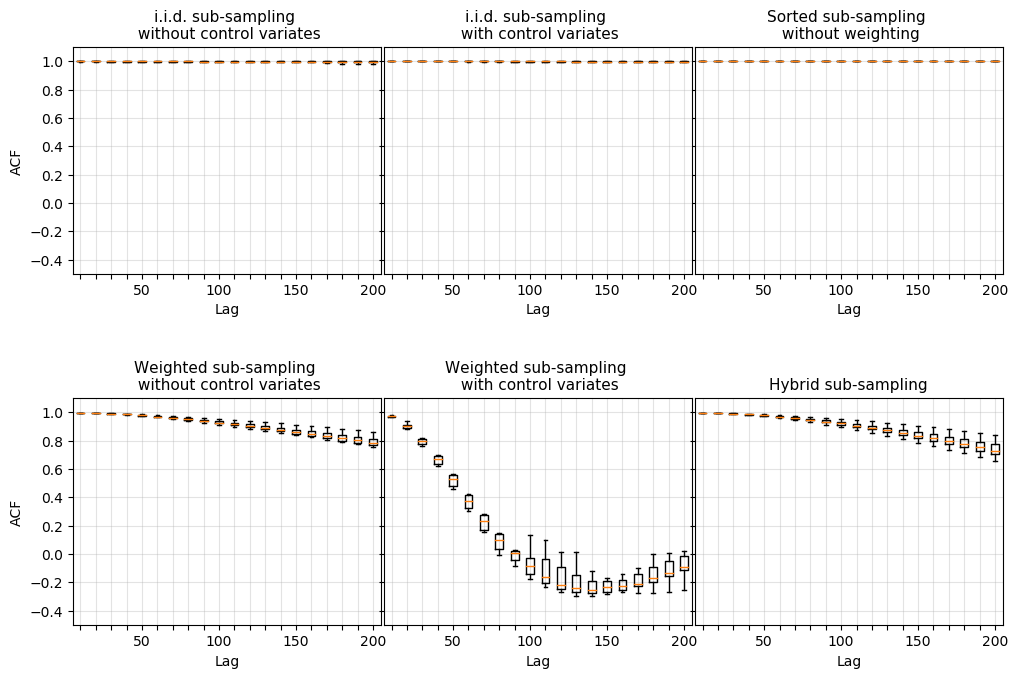

In [31]:
using PyPlot
fig = figure("pyplot_subplot_mixed", figsize=(12,7.5))

a, b = -.5, 1.1
subplot(231)
boxplot(acfs_iid, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
xticks(1:20, xt)
ylim([a,b])
title("i.i.d. sub-sampling \n without control variates", fontsize=11)

subplot(234)
boxplot(acfs_w, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
ylabel("ACF", fontsize=10)
ylim([a,b])
title("Weighted sub-sampling \n without control variates", fontsize=11)

subplot(233)
boxplot(acfs_sorted_uw, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
yticks(alpha=0)
ylim([a,b])
title("Sorted sub-sampling \n without weighting", fontsize=11)

subplot(232)
boxplot(acfs_CV_uw, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
yticks(alpha=0)
ylim([a,b])
title("i.i.d. sub-sampling \n with control variates", fontsize=11)

subplot(235)
boxplot(acfs_CV_w, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
yticks(alpha=0)
ylim([a,b])
title("Weighted sub-sampling \n with control variates", fontsize=11)

subplot(236)
boxplot(acfs_sorted_w, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
yticks(alpha=0)
ylim([a,b])
title("Hybrid sub-sampling", fontsize=11)

subplots_adjust(wspace=0.01, hspace=0.55)